In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import graph_policy
graph_policy.VARIABLE_NUM = 10

In [3]:
from graph_policy import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 64

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
META_FILE = "models/activepolicy-18-03-27-133558/model-640000.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/activepolicy-18-03-27-133558/model-640000


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 10

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] * BATCH_SIZE
        inputs = np.asarray([clauses_to_matrix(cnf.clauses) for cnf in cnfs])
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', cnfs[0].clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [14]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [15]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    #compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

#Sats: 100; avg step: 3.98; stdev step: 1.21; avg error: 0.76; stdev error: 0.67


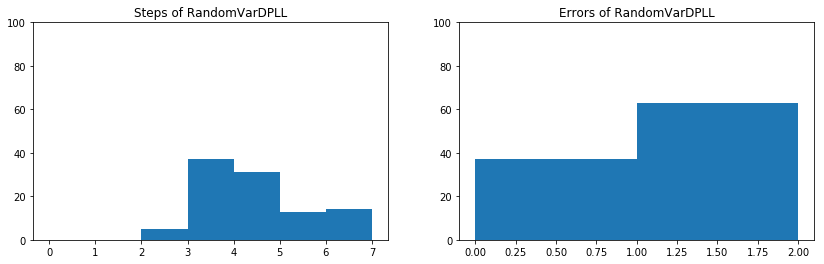

#Sats: 100; avg step: 3.03; stdev step: 0.82; avg error: 0.13; stdev error: 0.34


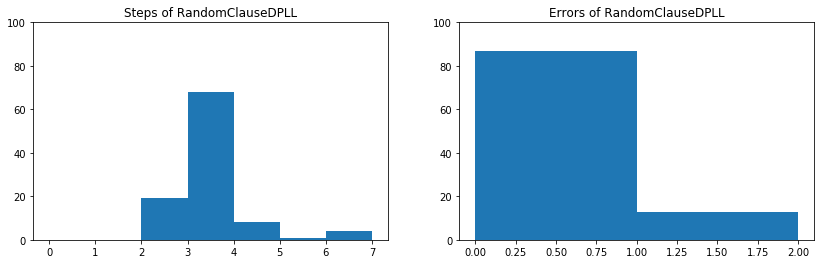

#Sats: 100; avg step: 2.99; stdev step: 0.66; avg error: 0.11; stdev error: 0.31


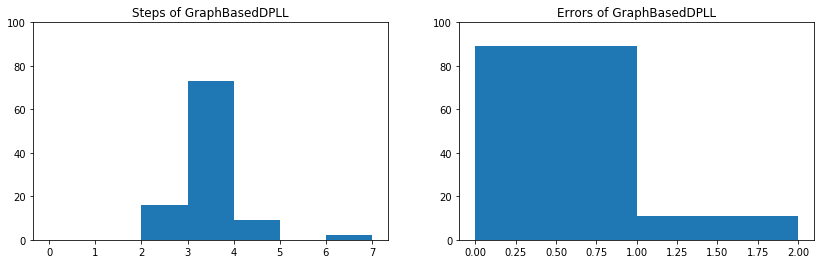

#Sats: 100; avg step: 2.72; stdev step: 0.45; avg error: 0.00; stdev error: 0.00


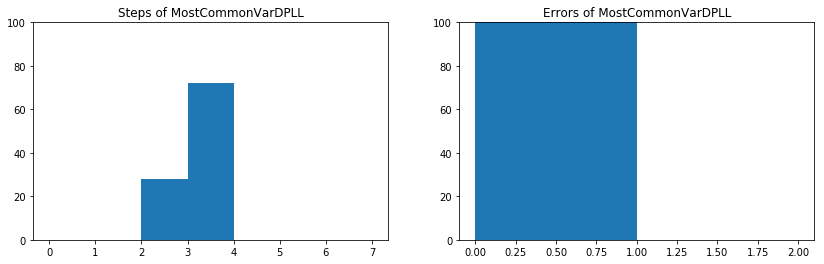

In [16]:
print_all(100, 2, 2, 3)

#Sats: 100; avg step: 8.39; stdev step: 2.47; avg error: 1.97; stdev error: 1.00


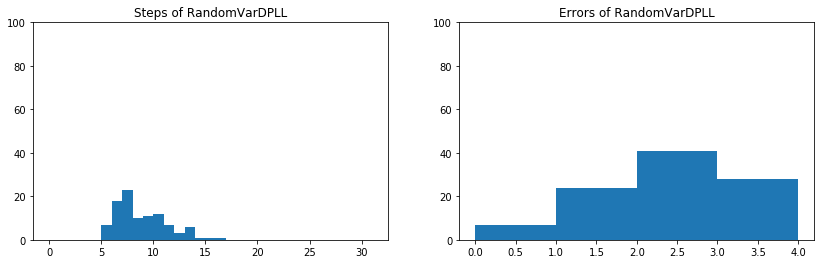

#Sats: 100; avg step: 6.86; stdev step: 2.22; avg error: 0.88; stdev error: 0.71


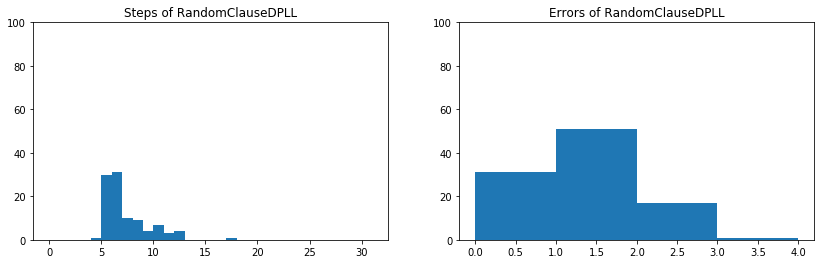

#Sats: 100; avg step: 5.59; stdev step: 0.87; avg error: 0.51; stdev error: 0.59


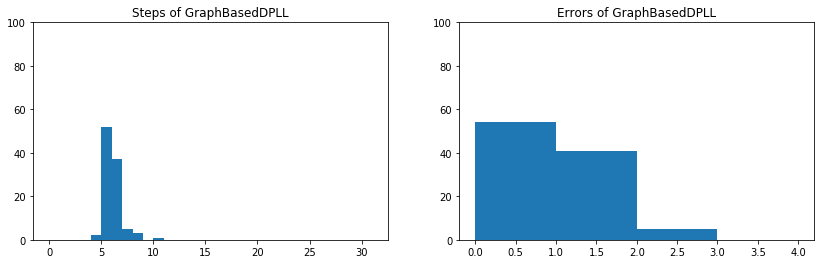

#Sats: 100; avg step: 5.16; stdev step: 0.97; avg error: 0.12; stdev error: 0.35


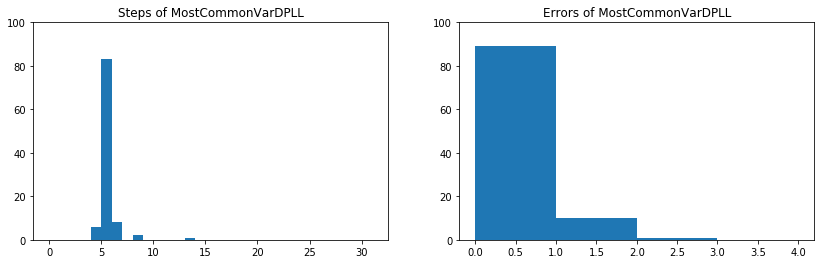

In [17]:
print_all(100, 2, 4, 20)

#Sats: 100; avg step: 7.64; stdev step: 3.92; avg error: 1.04; stdev error: 0.85


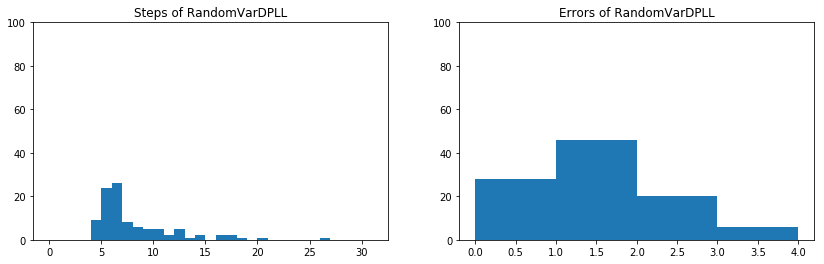

#Sats: 100; avg step: 5.43; stdev step: 2.08; avg error: 0.30; stdev error: 0.52


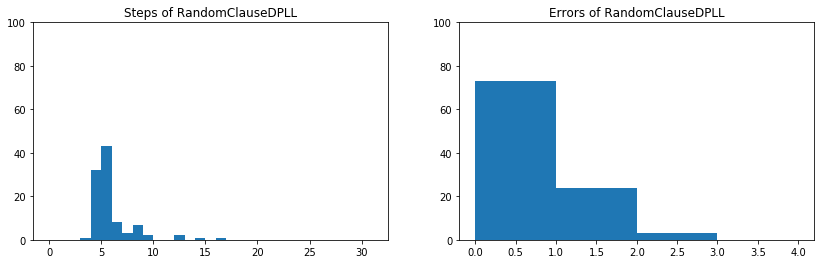

#Sats: 100; avg step: 5.10; stdev step: 1.54; avg error: 0.22; stdev error: 0.48


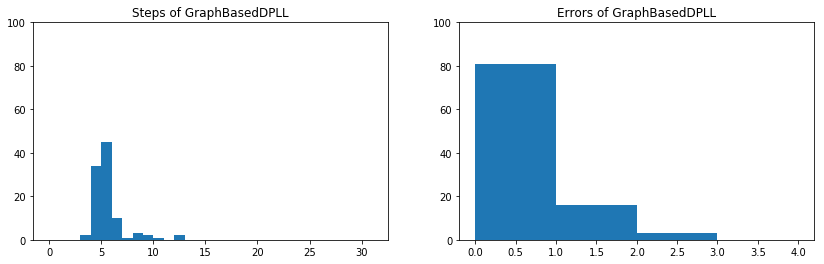

#Sats: 100; avg step: 4.52; stdev step: 1.17; avg error: 0.16; stdev error: 0.39


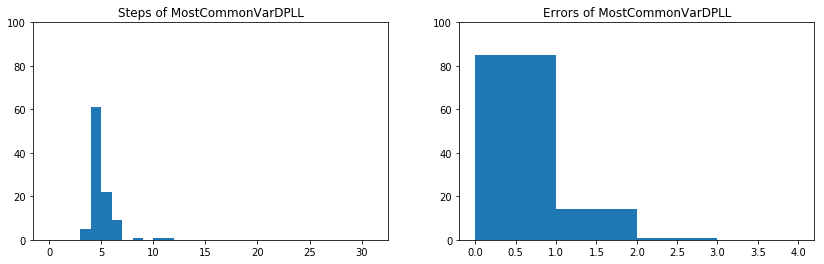

In [18]:
print_all(100, 3, 4, 10)

#Sats: 100; avg step: 11.45; stdev step: 5.56; avg error: 1.77; stdev error: 1.02


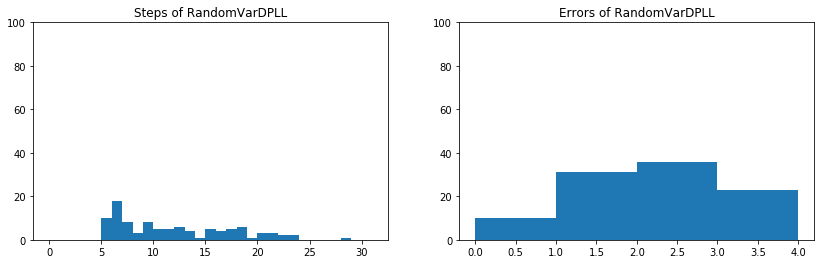

#Sats: 100; avg step: 7.99; stdev step: 3.76; avg error: 0.79; stdev error: 0.82


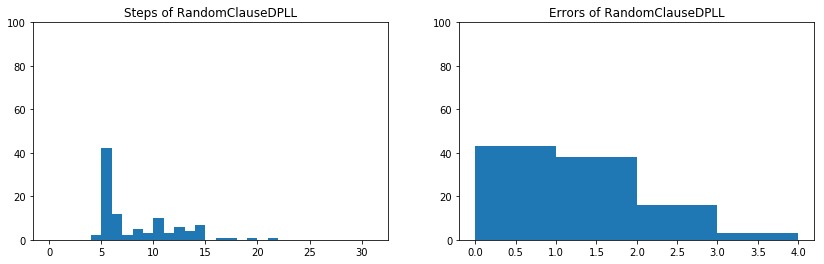

#Sats: 100; avg step: 6.89; stdev step: 3.64; avg error: 0.55; stdev error: 0.73


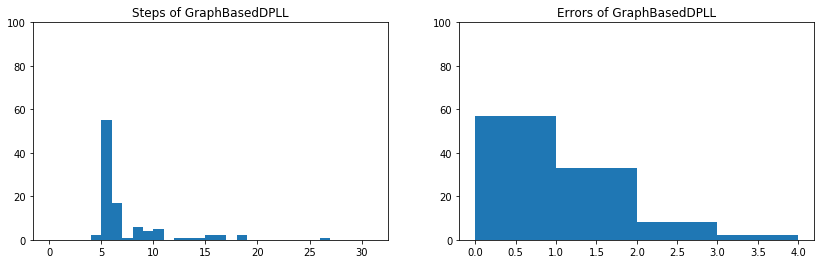

#Sats: 100; avg step: 6.19; stdev step: 2.66; avg error: 0.36; stdev error: 0.57


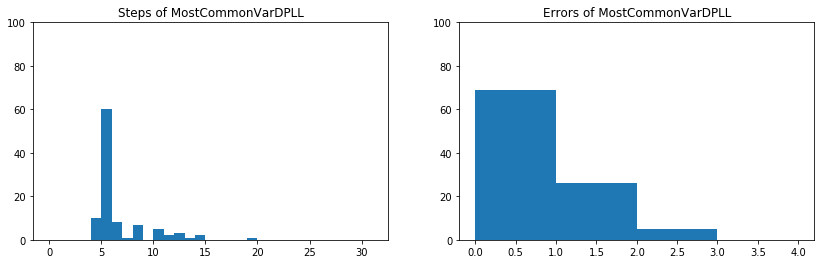

In [19]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 10.18; stdev step: 4.15; avg error: 2.00; stdev error: 1.17


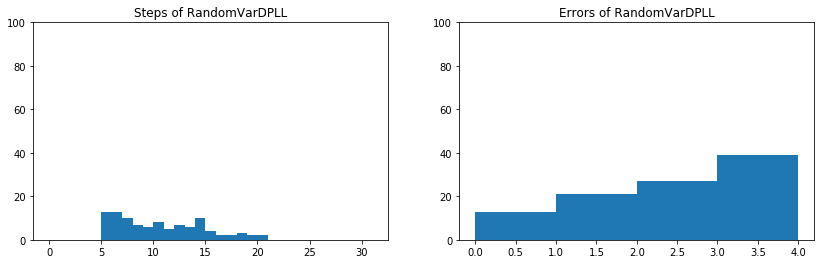

#Sats: 100; avg step: 8.51; stdev step: 3.22; avg error: 1.24; stdev error: 0.78


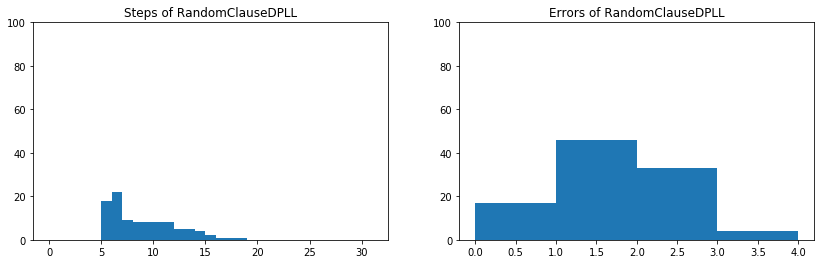

#Sats: 100; avg step: 6.56; stdev step: 2.78; avg error: 0.61; stdev error: 0.68


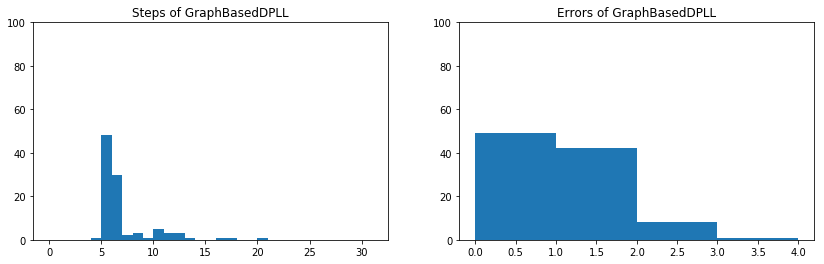

#Sats: 100; avg step: 6.00; stdev step: 2.22; avg error: 0.29; stdev error: 0.48


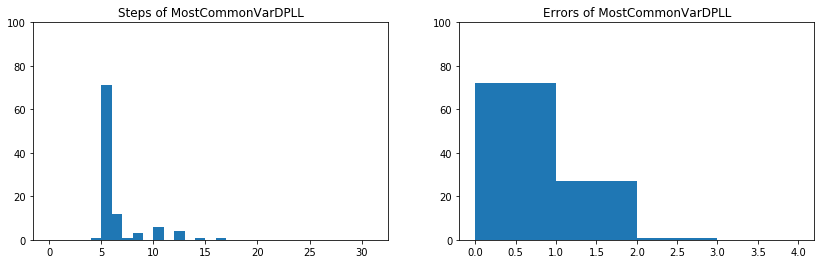

In [20]:
print_all(100, 3, 4, 40)

#Sats: 100; avg step: 14.45; stdev step: 7.33; avg error: 2.17; stdev error: 1.12


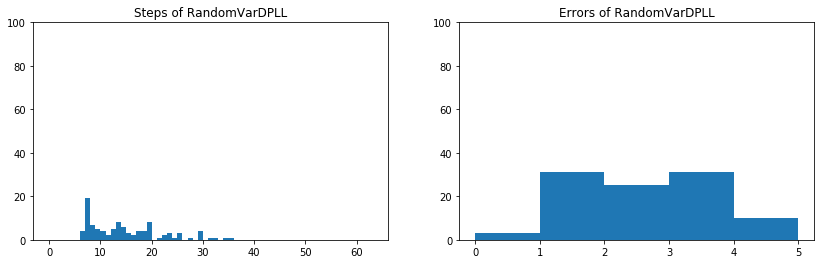

#Sats: 100; avg step: 11.71; stdev step: 5.82; avg error: 1.30; stdev error: 0.90


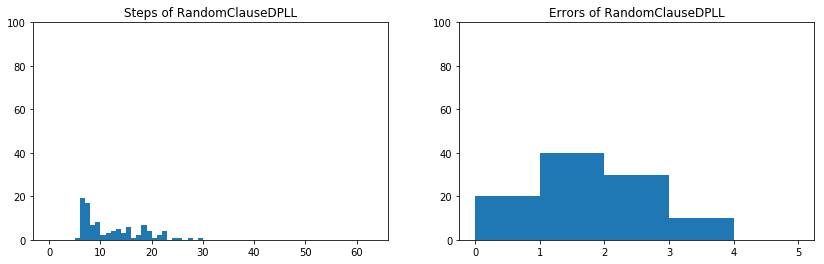

#Sats: 100; avg step: 9.51; stdev step: 6.24; avg error: 0.75; stdev error: 0.94


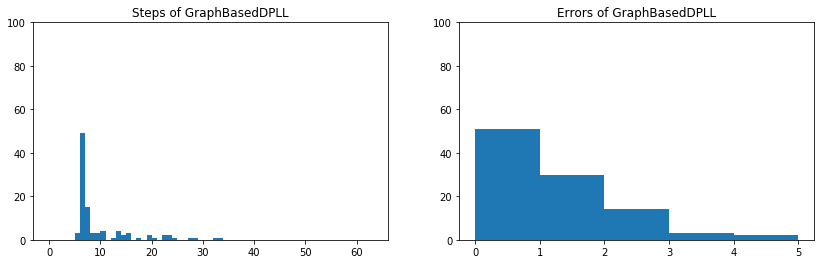

#Sats: 100; avg step: 8.14; stdev step: 4.23; avg error: 0.46; stdev error: 0.59


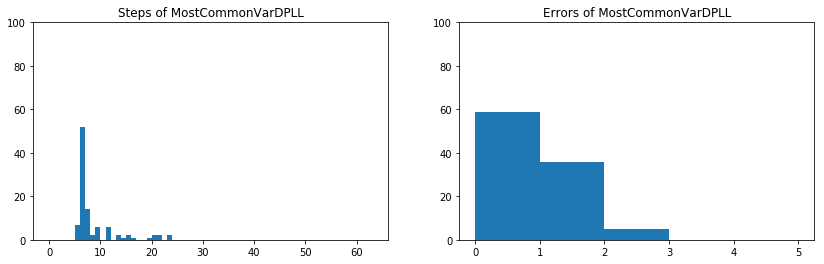

In [21]:
print_all(100, 3, 5, 30)

#Sats: 100; avg step: 14.16; stdev step: 6.19; avg error: 2.37; stdev error: 1.07


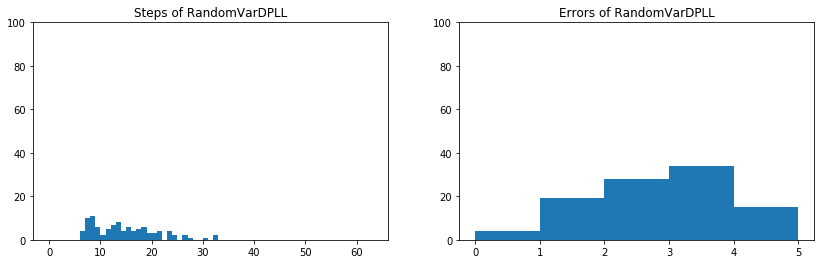

#Sats: 100; avg step: 12.86; stdev step: 5.61; avg error: 1.54; stdev error: 0.82


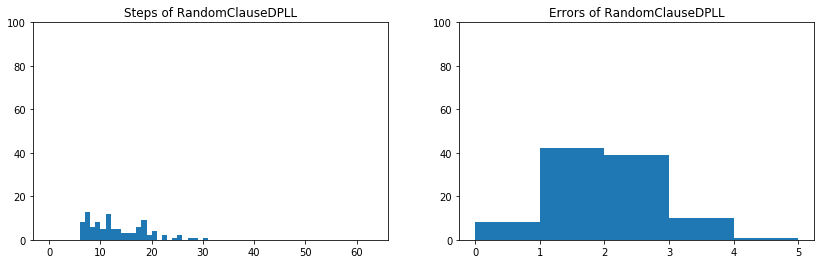

#Sats: 100; avg step: 8.53; stdev step: 5.10; avg error: 0.75; stdev error: 0.82


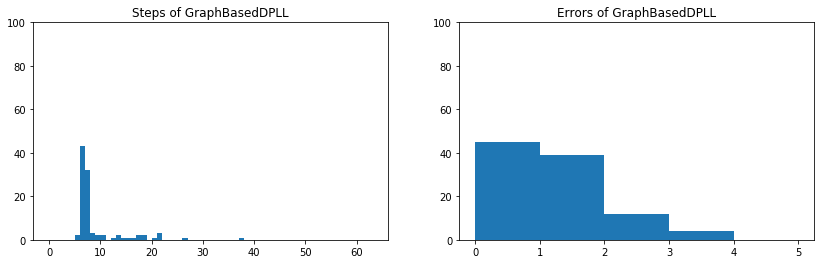

#Sats: 100; avg step: 7.54; stdev step: 3.71; avg error: 0.35; stdev error: 0.54


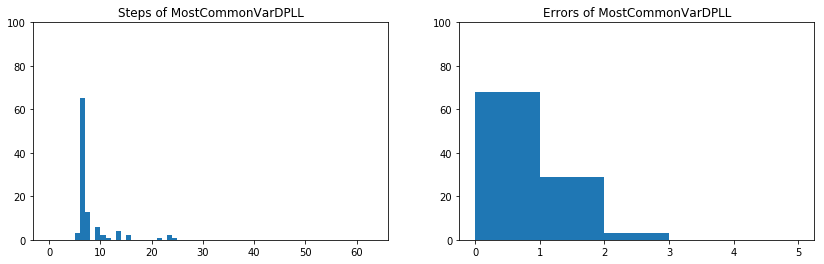

In [22]:
print_all(100, 3, 5, 40)

#Sats: 100; avg step: 18.74; stdev step: 9.89; avg error: 2.71; stdev error: 1.19


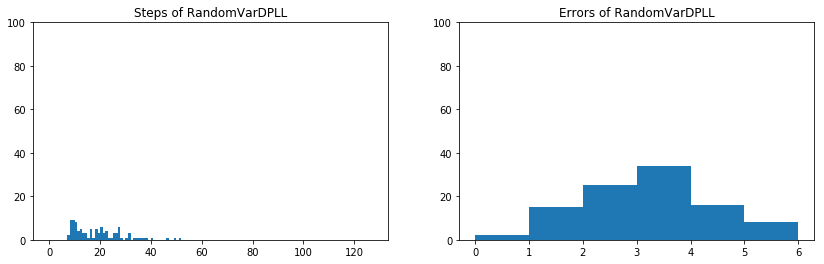

#Sats: 100; avg step: 17.86; stdev step: 8.81; avg error: 1.83; stdev error: 1.07


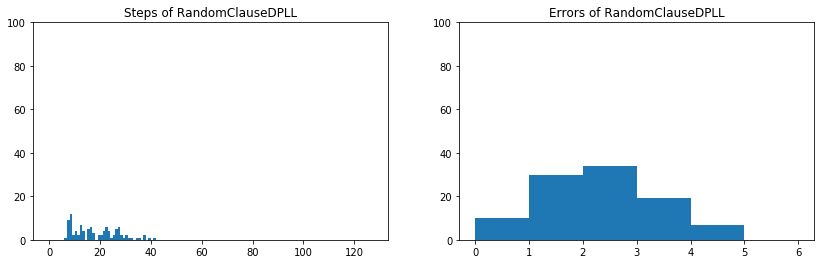

#Sats: 100; avg step: 12.59; stdev step: 9.72; avg error: 0.95; stdev error: 0.99


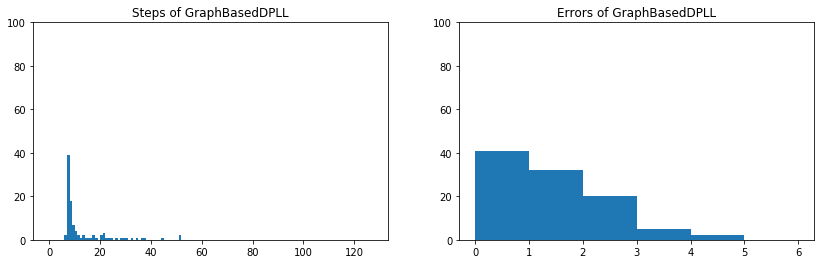

#Sats: 100; avg step: 9.55; stdev step: 5.24; avg error: 0.47; stdev error: 0.61


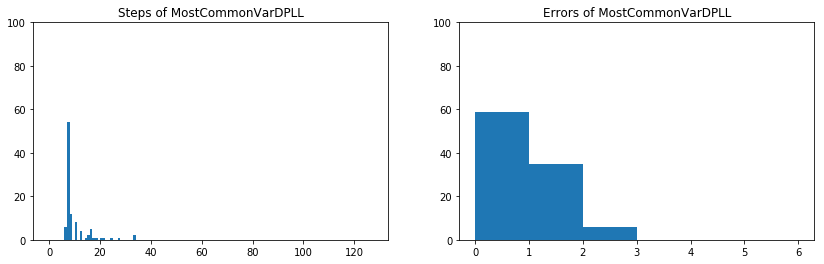

In [23]:
print_all(100, 3, 6, 40)

#Sats: 100; avg step: 17.21; stdev step: 6.50; avg error: 2.97; stdev error: 1.18


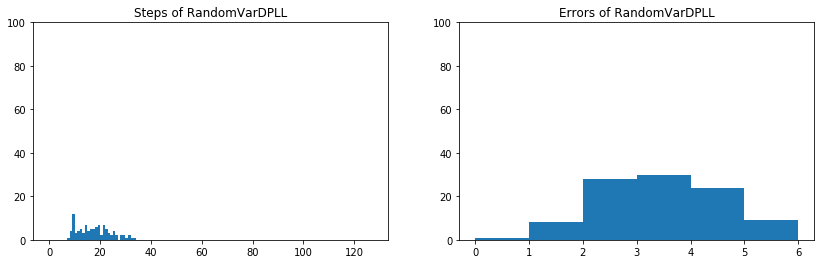

#Sats: 100; avg step: 15.93; stdev step: 6.82; avg error: 1.96; stdev error: 1.18


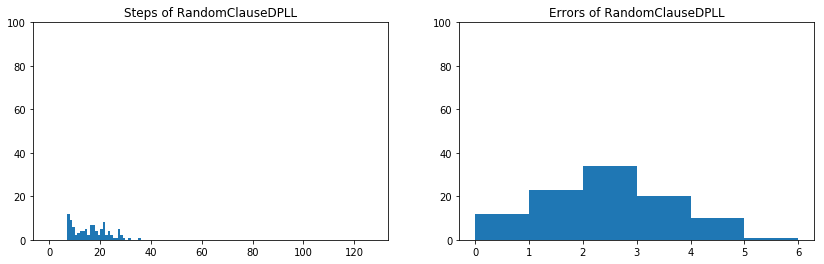

#Sats: 100; avg step: 9.32; stdev step: 4.09; avg error: 0.69; stdev error: 0.80


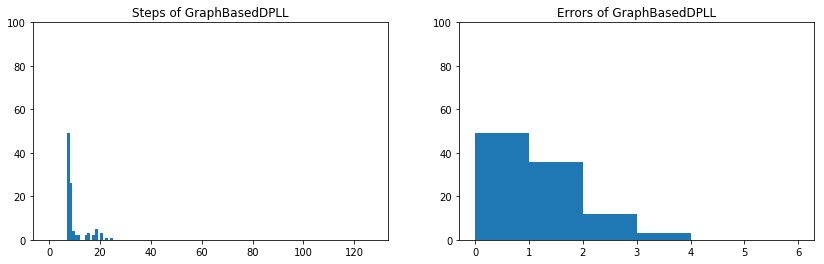

#Sats: 100; avg step: 8.07; stdev step: 2.69; avg error: 0.31; stdev error: 0.52


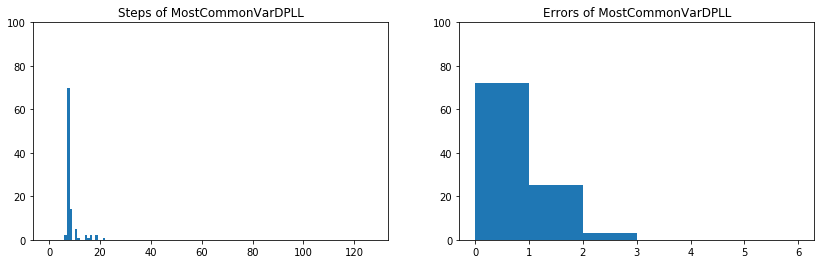

In [24]:
print_all(100, 3, 6, 70)

#Sats: 100; avg step: 22.15; stdev step: 16.61; avg error: 2.09; stdev error: 1.27


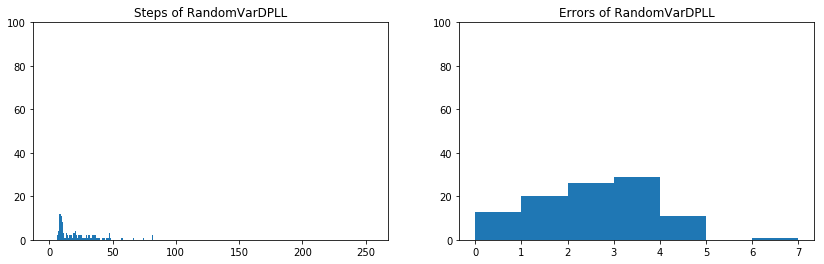

#Sats: 100; avg step: 14.01; stdev step: 10.45; avg error: 1.02; stdev error: 0.98


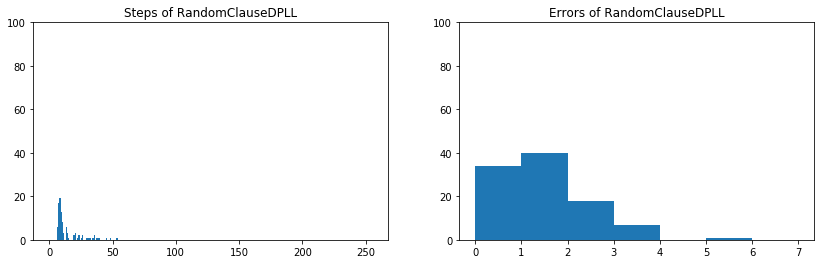

#Sats: 100; avg step: 10.33; stdev step: 10.90; avg error: 0.39; stdev error: 0.69


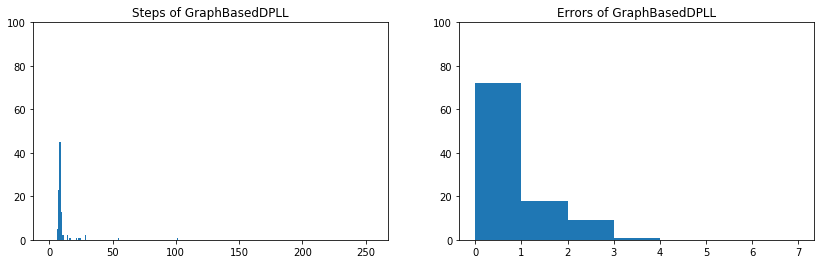

#Sats: 100; avg step: 8.97; stdev step: 5.09; avg error: 0.47; stdev error: 0.67


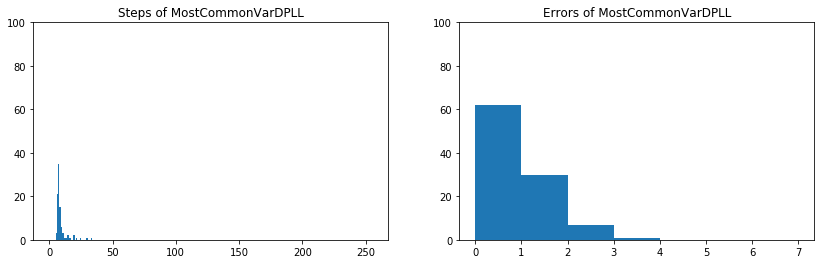

In [25]:
print_all(100, 3, 7, 20)

#Sats: 100; avg step: 23.04; stdev step: 9.71; avg error: 3.64; stdev error: 1.20


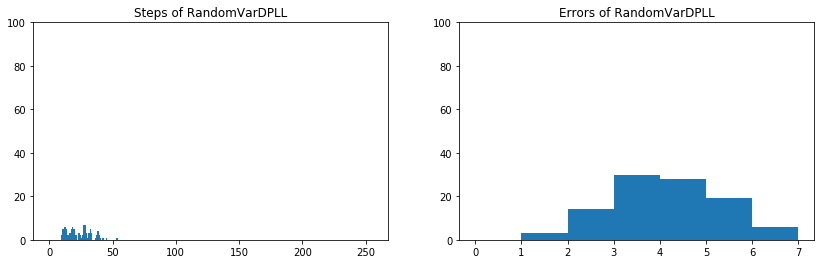

#Sats: 100; avg step: 19.71; stdev step: 9.75; avg error: 2.17; stdev error: 1.27


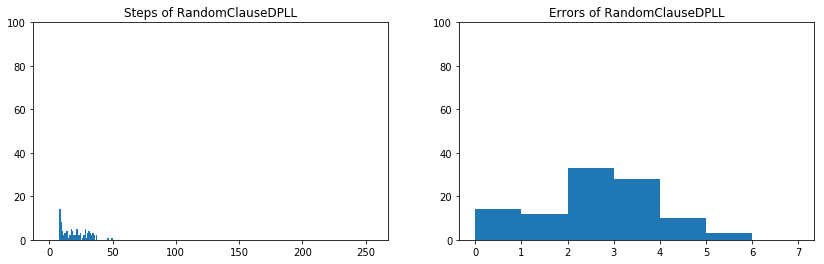

#Sats: 100; avg step: 14.51; stdev step: 10.15; avg error: 0.91; stdev error: 1.01


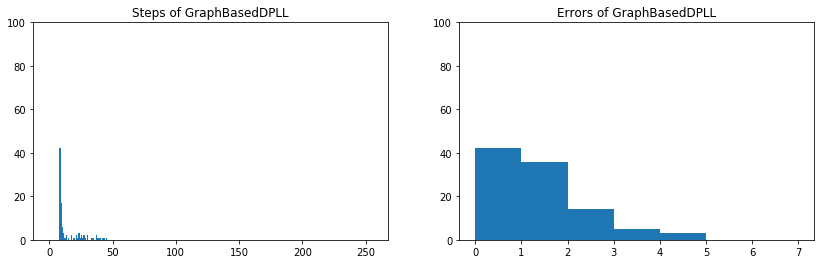

#Sats: 100; avg step: 10.79; stdev step: 5.50; avg error: 0.45; stdev error: 0.62


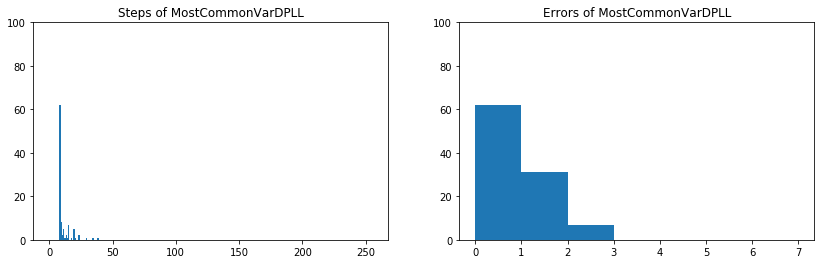

In [26]:
print_all(100, 3, 7, 70)

#Sats: 100; avg step: 40.41; stdev step: 26.06; avg error: 3.54; stdev error: 1.37


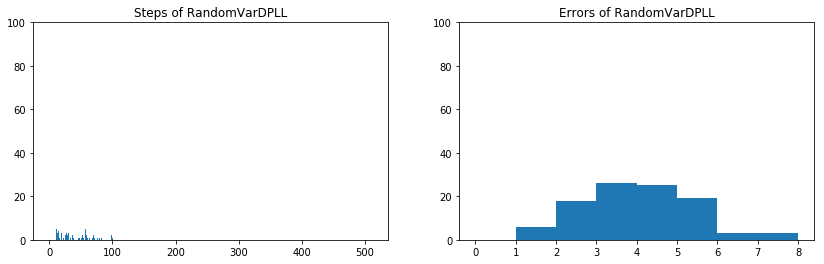

#Sats: 100; avg step: 28.10; stdev step: 19.97; avg error: 1.93; stdev error: 1.14


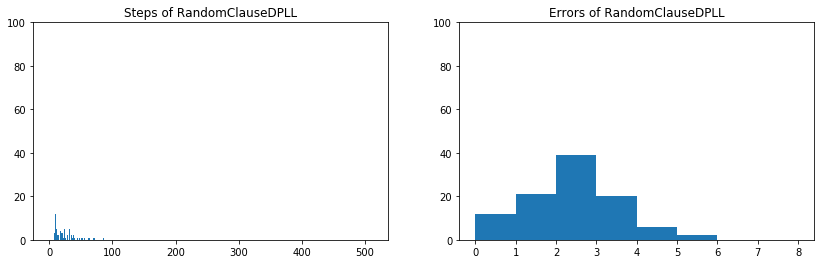

#Sats: 100; avg step: 25.62; stdev step: 27.23; avg error: 0.99; stdev error: 1.00


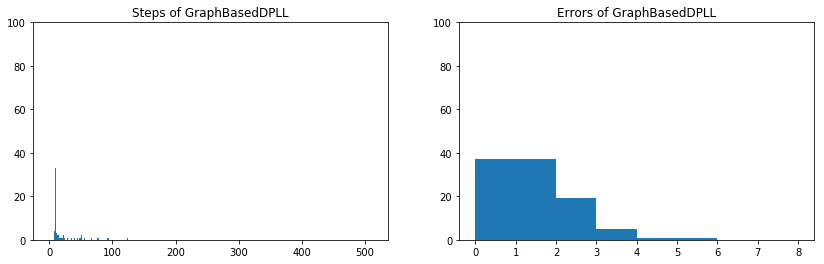

#Sats: 100; avg step: 17.79; stdev step: 12.26; avg error: 0.82; stdev error: 0.77


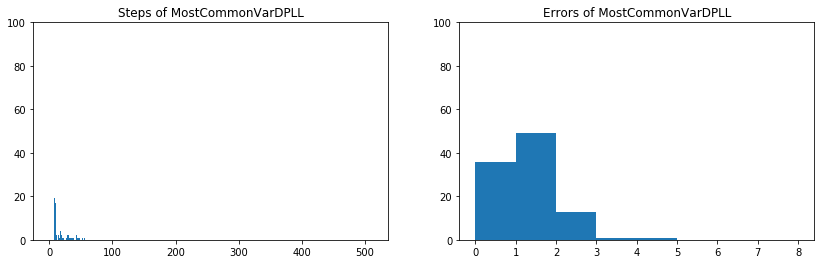

In [27]:
print_all(100, 3, 8, 40)

#Sats: 100; avg step: 35.60; stdev step: 20.74; avg error: 3.51; stdev error: 1.40


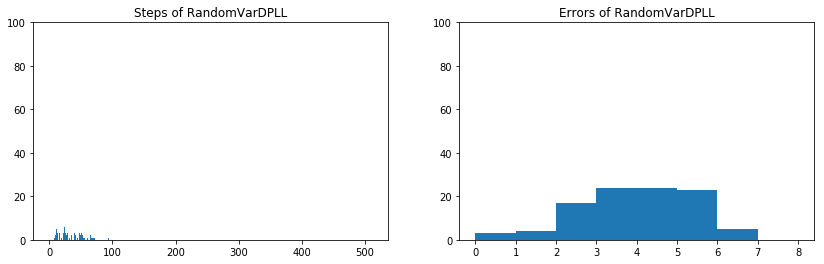

#Sats: 100; avg step: 27.72; stdev step: 14.05; avg error: 2.15; stdev error: 1.19


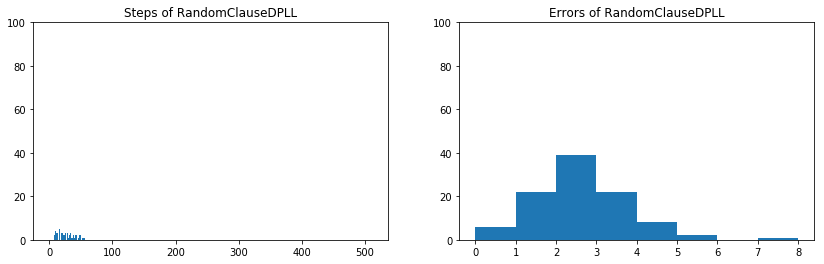

#Sats: 100; avg step: 25.78; stdev step: 23.83; avg error: 1.11; stdev error: 1.05


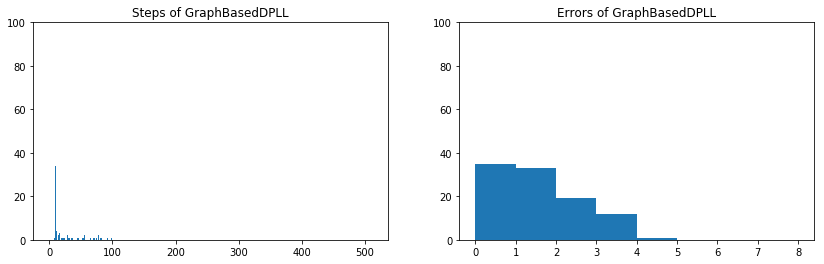

#Sats: 100; avg step: 14.52; stdev step: 10.53; avg error: 0.65; stdev error: 0.74


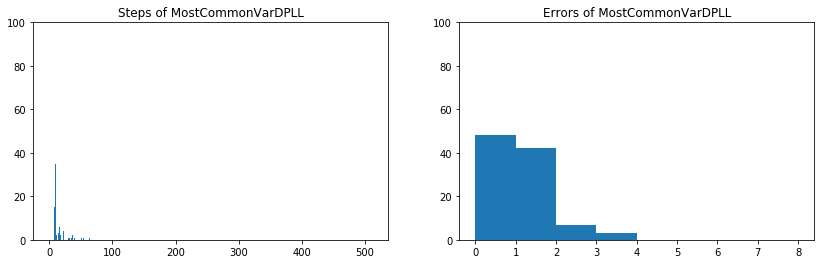

In [28]:
print_all(100, 3, 8, 50)

#Sats: 100; avg step: 68.63; stdev step: 40.55; avg error: 4.54; stdev error: 1.48


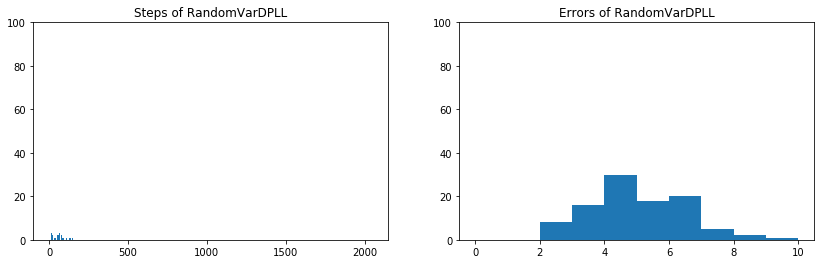

#Sats: 100; avg step: 49.69; stdev step: 37.50; avg error: 2.58; stdev error: 1.31


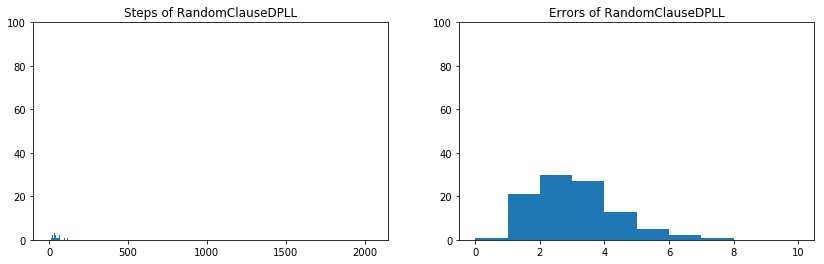

#Sats: 100; avg step: 58.48; stdev step: 59.12; avg error: 1.37; stdev error: 1.07


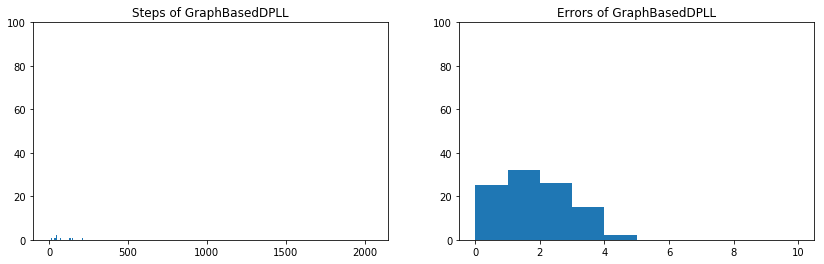

#Sats: 100; avg step: 22.86; stdev step: 19.84; avg error: 0.92; stdev error: 1.01


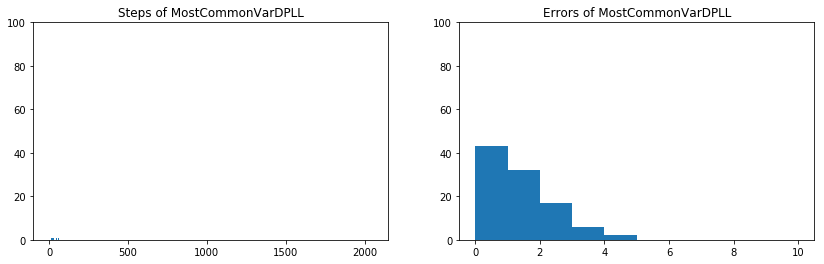

In [29]:
print_all(100, 3, 10, 50)